In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml chromadb tiktoken opencv-python

In [3]:
!pip install langchain_core
!pip install langchain-google-genai
!pip install langchain
!pip install langchain_community

In [1]:
%pip install -U nltk

In [2]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [12]:
import os
from google.colab import userdata
GOOGLE_API_KEY =userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
output_path = "./images"

In [5]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/HKDSE_PHYSICS_PAST_PAPER_1_ENG.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
raw_pdf_elements

In [23]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm= ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-pro"),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [24]:
len(table_summaries)

6

In [25]:
len(text_summaries)

13

In [27]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatGoogleGenerativeAI(model="gemini-1.5-flash").invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [29]:
len(image_summaries)

81

In [30]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 42.9 MB/s eta 0:00:00


In [31]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

In [32]:
vectorstore.save_local("faiss_index")

In [35]:
prompt_template = """
You are an expert in Hardware related products and related product guides that contains specification, features, etc.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [36]:
qa_chain = LLMChain(llm=ChatGoogleGenerativeAI(model="gemini-1.5-pro", max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [37]:
qa_chain

LLMChain(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nYou are an expert in Hardware related products and related product guides that contains specification, features, etc.\nAnswer the question based only on the following context, which can include text, images and tables:\n{context}\nQuestion: {question}\nDon\'t answer if you are not sure and decline to answer and say "Sorry, I don\'t have much information about it."\nJust return the helpful answer in as much as detailed possible.\nAnswer:\n'), llm=ChatGoogleGenerativeAI(model='models/gemini-1.5-pro', client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7c97c5b47910>, async_client=<google.ai.generativelanguage_v1beta.services.generative_service.async_client.GenerativeServiceAsyncClient object at 0x7c97c5b478e0>, default_metadata=()))

In [38]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [48]:
q= "As shown above, a ray of light travels from medium 1 to medium 2, and then enters medium 3. The boundaries are parallel to each other. Arrange the speed of light, c, in the three media in ascending order."

In [49]:
result, relevant_images = answer(q)
print(result)

Here's how to determine the order of the speed of light in the three media:

**Understanding Snell's Law and the Relationship Between Speed and Refractive Index**

* **Snell's Law:** This law describes how light bends (refracts) when it passes from one medium to another. It's given by the equation: 
   *  *n₁ sinθ₁ = n₂ sinθ₂* 
   * Where:
      * n₁ and n₂ are the refractive indices of the first and second media, respectively.
      * θ₁ is the angle of incidence (angle between the incident ray and the normal).
      * θ₂ is the angle of refraction (angle between the refracted ray and the normal).

* **Refractive Index and Speed of Light:** The refractive index (n) of a material indicates how much slower light travels in that material compared to a vacuum.  
   *  *n = c / v*
   * Where:
      * c is the speed of light in a vacuum (approximately 3 x 10⁸ m/s).
      * v is the speed of light in the material.

**Analyzing the Diagram**

1. **Medium 1 to Medium 2:** The light ray bends *

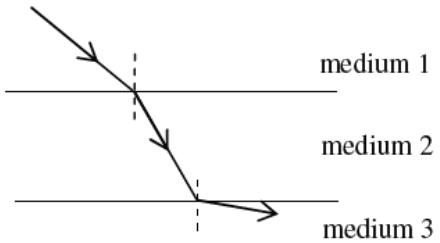

In [53]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [40]:
# Display result
result, relevant_images = answer("sprinkler system")
print(result)

The diagram shows a simplified illustration of a rooftop sprinkler system for cooling purposes. Here's how it works and why it's effective:

* **Evaporative Cooling:** The core principle is the process of evaporation. When water droplets from the sprinklers land on the hot rooftop surface, they absorb heat from the roof and the surrounding air. This absorbed heat transforms the liquid water into water vapor (a gas) – the process of evaporation.

* **High Latent Heat of Vaporization:**  Water has a high latent heat of vaporization, meaning it requires a significant amount of heat energy to change from liquid to vapor.  As the water droplets on the roof evaporate, they draw this needed heat from their surroundings, effectively cooling down the rooftop surface.

* **Continuous Cycle:** The sprinkler system provides a continuous supply of water. As older droplets evaporate, new ones are sprayed on, maintaining the cooling effect.

**Benefits:**

* **Reduced Cooling Costs:** By lowering the

In [41]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEoAdQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAELBVLMQAOpNRidJIDLAyzDBI2MCG9s1y/i/Qdb8Rz29ha6gLHSjzdPGSJX9ge351v6PpNtoelQadaBvJhXC72LE98kmgDkk8UeMrm9K2/hAi2EuwySXCA4

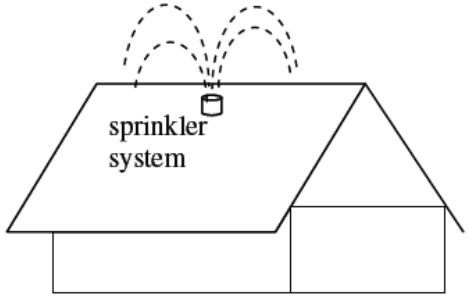

In [47]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

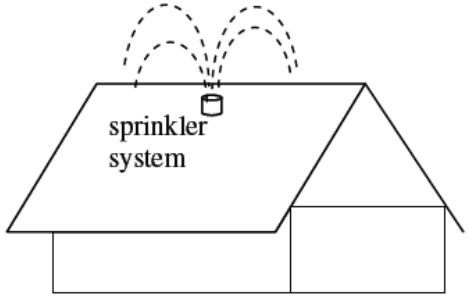

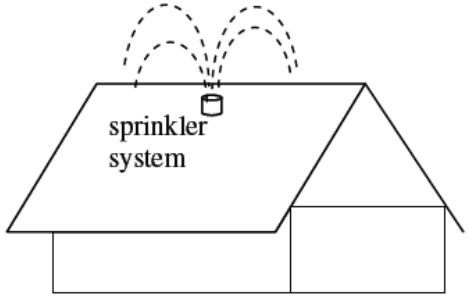

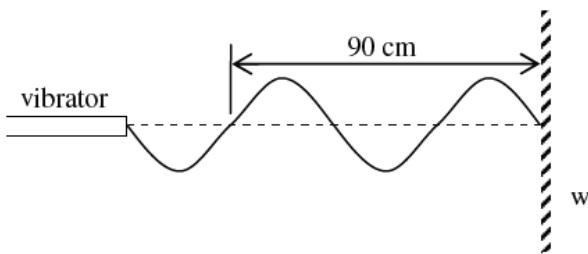

In [42]:
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

In [43]:
query = "What sprinkler system?"
docs = vectorstore.similarity_search(query)

In [44]:
docs

[Document(metadata={'id': '0bb455e8-c159-4deb-adcd-ac3ebb2a68d5', 'type': 'image', 'original_content': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEoAdQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAELBVLMQAOpNRidJI

In [46]:
docs[0].page_content

'The image shows a simple line drawing of a house with a sprinkler system on the roof. The sprinkler system is represented by a small box with water spraying from it in an arc shape. The words "sprinkler system" are written below the sprinkler.'

In [56]:
q1 = "A disc of mass 0.1 kg and velocity 5m * s ^ - 1 strikes a stationary disc of mass 0.2 kg on a smooth table. After the collision, the 0.1 kg disc moves with a speed of 3m * s ^ - 1 at 50° to the x direction. Find the component of the velocity of the 0.2 kg disc in y direction, v_{y} after the collision."

In [57]:
result, relevant_images = answer(q1)
print(result)

Here's how to solve this problem using the principle of conservation of momentum:

**Understanding the Problem**

We have a two-dimensional collision problem.  A disc (let's call it disc A) strikes a stationary disc (disc B). We need to find the y-component of disc B's velocity *after* the collision.

**Key Concept: Conservation of Momentum**

In a closed system, the total momentum before a collision equals the total momentum after the collision. Momentum is a vector quantity, meaning it has both magnitude and direction. Therefore, we need to consider momentum in both the x and y directions separately.

**Setting Up the Solution**

* **Let:**
    *  m<sub>A</sub> = mass of disc A = 0.1 kg
    *  m<sub>B</sub> = mass of disc B = 0.2 kg
    *  u<sub>A</sub> = initial velocity of disc A = 5 m/s 
    *  u<sub>B</sub> = initial velocity of disc B = 0 m/s (stationary)
    *  v<sub>Ax</sub> = x-component of final velocity of disc A = 3 m/s * cos(50°) 
    *  v<sub>Ay</sub> = y-component of fi

In [58]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFxAlIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorjPif4t/4RHwfcXMT7bycGK39Qx/iH0yDQB2dcf4+8Q6v4Z0+DULBIJLfzVSYS

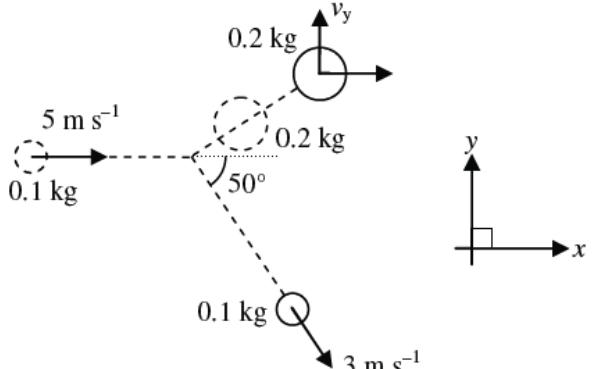

In [59]:
display.display(display.Image(base64.b64decode(relevant_images[0])))